In [ ]:
# 디바이스 설정
import tensorflow as tf
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# read_csv
data_path = '/content/drive/MyDrive/프로젝트/데이콘_비트/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv") #임의의 시점 부터 2021년 1월 31일까지 9가지 종류의 암호화폐의 분단위 가격정보를 가공한 데이터
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv") #2021년 2월 1일 부터 임의의 시점까지 9가지 종류의 암호화폐의 분단위 가격정보를 가공한 데이터

In [ ]:
test_x_df.shape

(730020, 12)

In [ ]:
train_x_df['coin_index'].value_counts()/1380

9    1178.0
8    1178.0
6    1065.0
7     947.0
4     930.0
0     907.0
5     545.0
1     382.0
3     129.0
2     101.0
Name: coin_index, dtype: float64

In [ ]:
train_x_9 = train_x_df.query('coin_index==9')
train_y_9 = train_y_df.query('coin_index==9')
test_x_9 = test_x_df.query('coin_index==9')

In [ ]:
train_x_dff = train_x_9.diff(1)

In [ ]:
train_x_dff

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
5520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5521,0.0,1.0,0.0,-0.000600,-0.000583,-0.000064,-0.000038,-0.005403,-41.616404,-0.005451,0.000676,5.199565
5522,0.0,1.0,0.0,-0.000105,-0.000036,0.000108,-0.000067,0.000236,1.814329,-0.002973,-0.000045,-0.346912
5523,0.0,1.0,0.0,-0.000114,0.000867,0.000001,0.001049,0.014736,113.486397,0.023167,0.014196,109.323263
5524,0.0,1.0,0.0,0.001051,0.000351,0.000133,-0.000763,-0.010109,-77.825645,0.000619,-0.011875,-91.433542
...,...,...,...,...,...,...,...,...,...,...,...,...
10155415,0.0,1.0,0.0,-0.000026,-0.000034,-0.000354,-0.000267,-0.000570,-6.130483,0.002796,-0.000911,-9.798850
10155416,0.0,1.0,0.0,-0.000267,-0.000301,-0.000368,-0.000439,0.002039,21.900031,0.020969,0.001379,14.821170
10155417,0.0,1.0,0.0,-0.000440,-0.000438,-0.001290,-0.001069,0.002999,32.157543,0.051816,-0.000128,-1.397860
10155418,0.0,1.0,0.0,-0.001060,-0.000760,-0.000016,-0.000071,-0.004110,-44.122128,-0.045013,-0.000364,-3.907094


In [ ]:
# numpy array로 변환하기
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1] #sample_id, time 제외
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [ ]:
train_x_9_array = df2d_to_array3d(train_x_9)
train_y_9_array = df2d_to_array3d(train_y_9)
test_x_9_array = df2d_to_array3d(test_x_9)

print(f'''
train_x_9array {train_x_9_array.shape} #sample_id size, time, feature
train_y_9array {train_y_9_array.shape}
test_x_9_array {test_x_9_array.shape}
''')


train_x_9array (1178, 1380, 10) #sample_id size, time, feature
train_y_9array (1178, 120, 10)
test_x_9_array (52, 1380, 10)



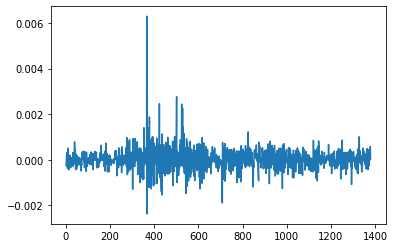

In [ ]:
plt.plot(pd.DataFrame(train_x_9_array[1, :, 1]).diff(1))

In [ ]:
train_x_1 = pd.DataFrame(train_x_9_array[1, :, 1]).diff(1).dropna()
test_x_1 = pd.DataFrame(train_y_9_array[1, :, 1]).diff(1).dropna()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
train_x_1_transform = min_max_scaler.fit_transform(train_x_1)

In [ ]:
train_x_1_transform

array([[0.24464931],
       [0.27450724],
       [0.29599945],
       ...,
       [0.29050256],
       [0.34096522],
       [0.27469299]])

In [ ]:
def split_xy1(dataset, time_steps):
  x, y = list(), list()
  for i in range(len(dataset)):
    end_number = i + time_steps
    if end_number > len(dataset)-1:
      break
    tmp_x, tmp_y = dataset[i:end_number], dataset[end_number]
    x.append(tmp_x)
    y.append(tmp_y)
  return np.array(x), np.array(y)

In [ ]:
x_train, y_train = split_xy1(train_x_1_transform, 60)
#x_test = train_x_9_array[1, 1320:1381, 1].reshape(1, 60)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(GRU(300, input_shape = (60, 1)))
model.add(Dense(50))
model.add(Dense(1))

In [ ]:
x_train.shape

(1319, 60, 1)

In [ ]:
model.compile(optimizer='adam', loss='mae')
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
42/42 [==============================] - 1s 6ms/step - loss: 0.0898
Epoch 2/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0348
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 4/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 6/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0359
Epoch 7/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 8/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 9/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0339
Epoch 10/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0356
Epoch 11/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0346
Epoch 12/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0356
Epoch 13/100
42/42 [=================

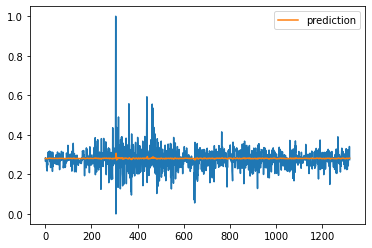

In [ ]:
pred1 = model.predict(x_train)
plt.plot(y_train)
plt.plot(pred1, label='prediction')
plt.legend()

In [ ]:
x_train, y_train

(array([[[0.24464931],
         [0.27450724],
         [0.29599945],
         ...,
         [0.24749751],
         [0.27332393],
         [0.27833236]],
 
        [[0.27450724],
         [0.29599945],
         [0.31061883],
         ...,
         [0.27332393],
         [0.27833236],
         [0.26899659]],
 
        [[0.29599945],
         [0.31061883],
         [0.27980462],
         ...,
         [0.27833236],
         [0.26899659],
         [0.284015  ]],
 
        ...,
 
        [[0.28107048],
         [0.24554367],
         [0.25015307],
         ...,
         [0.31426508],
         [0.28352654],
         [0.28391868]],
 
        [[0.24554367],
         [0.25015307],
         [0.20674899],
         ...,
         [0.28352654],
         [0.28391868],
         [0.29050256]],
 
        [[0.25015307],
         [0.20674899],
         [0.32829968],
         ...,
         [0.28391868],
         [0.29050256],
         [0.34096522]]]), array([[0.26899659],
        [0.284015  ],
        [0.2

In [ ]:
x_test.shape

(1, 60, 1)

In [ ]:
y_pred = []

for i in range(120):
  pred = model.predict(x_test[:, i:i+60, :])
  y_pred = np.append(y_pred, pred)
  print(y_pred)
  x_test = np.append(x_test, pred).reshape(1, -1, 1)

[0.99932593]
[0.99932593 0.99871033]
[0.99932593 0.99871033 0.9981184 ]
[0.99932593 0.99871033 0.9981184  0.99752486]
[0.99932593 0.99871033 0.9981184  0.99752486 0.99692851]
[0.99932593 0.99871033 0.9981184  0.99752486 0.99692851 0.99633628]
[0.99932593 0.99871033 0.9981184  0.99752486 0.99692851 0.99633628
 0.99574345]
[0.99932593 0.99871033 0.9981184  0.99752486 0.99692851 0.99633628
 0.99574345 0.99515146]
[0.99932593 0.99871033 0.9981184  0.99752486 0.99692851 0.99633628
 0.99574345 0.99515146 0.99456072]
[0.99932593 0.99871033 0.9981184  0.99752486 0.99692851 0.99633628
 0.99574345 0.99515146 0.99456072 0.99397045]
[0.99932593 0.99871033 0.9981184  0.99752486 0.99692851 0.99633628
 0.99574345 0.99515146 0.99456072 0.99397045 0.99338126]
[0.99932593 0.99871033 0.9981184  0.99752486 0.99692851 0.99633628
 0.99574345 0.99515146 0.99456072 0.99397045 0.99338126 0.99279279]
[0.99932593 0.99871033 0.9981184  0.99752486 0.99692851 0.99633628
 0.99574345 0.99515146 0.99456072 0.99397045 

In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

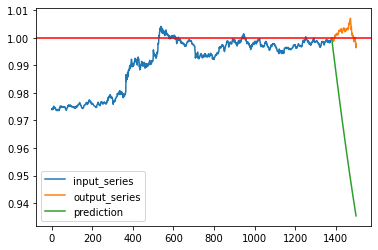

In [ ]:
plot_series(train_x_9_array[1, :, 1], train_y_9_array[1, :, 1])
plt.plot(np.arange(1380, 1380+120), y_pred, label='prediction')
plt.legend()

In [ ]:
y_pred

array([0.99877864, 0.99839842, 0.99801695, 0.99764568, 0.99728936,
       0.99694973, 0.99662709, 0.99632078, 0.99603045, 0.99575508,
       0.99549401, 0.99524647, 0.99501181, 0.99478942, 0.99457842,
       0.99437845, 0.99418873, 0.9940092 , 0.99383867, 0.99367708,
       0.9935239 , 0.9933787 , 0.99324101, 0.99311042, 0.99298656,
       0.99286926, 0.99275798, 0.99265254, 0.99255252, 0.99245763,
       0.9923678 , 0.99228257, 0.99220175, 0.99212509, 0.99205256,
       0.99198353, 0.99191833, 0.9918564 , 0.99179769, 0.99174201,
       0.99168921, 0.9916392 , 0.99159169, 0.99154663, 0.99150401,
       0.9914636 , 0.99142528, 0.99138892, 0.99135447, 0.9913218 ,
       0.99129087, 0.99126142, 0.99123353, 0.99120706, 0.99118203,
       0.99115837, 0.99113584, 0.99111444, 0.99109417, 0.99107498,
       0.99105674, 0.99103951, 0.99102312, 0.99100757, 0.99099278,
       0.9909789 , 0.99096572, 0.99095321, 0.99094129, 0.99093008,
       0.99091935, 0.99090922, 0.99089962, 0.99089062, 0.99088